In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
# ------------------------------
# Step 1: Load and Preprocess Data (Algorithm Step 1)
# ------------------------------
df = pd.read_csv('/content/drive/MyDrive/Security/ConPu/data/Augmented_Positive_Unlabeled_Data.csv')  # Load dataset

In [ ]:
df.head(5)

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,session_id,label
0,0.588431,0.515397,0.777830,0.934387,0.814081,0.539578,0.764568,0.905214,0.937845,0.786522,L_0,1.0
1,0.985445,0.604778,0.922284,0.742365,0.930386,0.636544,0.984141,0.592476,0.932700,0.667233,L_1,1.0
2,0.732084,0.575385,0.654222,0.559929,0.865931,0.922480,0.679654,0.614272,0.800431,0.802691,L_2,1.0
3,0.782528,0.719383,0.829432,0.735783,0.978508,0.780089,0.894002,0.955449,0.776133,0.810991,L_3,1.0
4,0.895528,0.623887,0.536190,0.731760,0.989185,0.643151,0.799138,0.764609,0.867900,0.962879,L_4,1.0


In [ ]:
import pandas as pd

# Suppose your DataFrame is called df
# and 'label' is either 1.0 for positives or NaN (or some other placeholder) for “unlabeled.”

# 1. Count how many non‐null labels there are:
num_labeled = df['label'].notna().sum()
# 2. Count how many null labels (i.e. “unlabeled”):
num_unlabeled = df['label'].isna().sum()

print(f"Number of labeled samples:   {num_labeled}")
print(f"Number of unlabeled samples: {num_unlabeled}")

# 3. If your “unlabeled” rows are indicated by some specific value (e.g. label = 0.0),
#    you can also do a value_counts:
print("\nValue counts for the 'label' column:\n", df['label'].value_counts(dropna=False))


Number of labeled samples:   8001
Number of unlabeled samples: 6999

Value counts for the 'label' column:
 label
1.0    7470
NaN    6999
0.0     531
Name: count, dtype: int64


# Final Conpu Framework with t-SNE

D1 (positives) size:      7470
Neg (known negatives) size:531
Unlabeled size:           6999
[Stage 1 | Epoch 1/20] raw_tau = 1.4427, tau = 2.0000
  → Loss: 0.5679

[Stage 1 | Epoch 2/20] raw_tau = 0.9102, tau = 2.0000
  → Loss: 0.0740

[Stage 1 | Epoch 3/20] raw_tau = 0.7213, tau = 2.0000
  → Loss: 0.0383

[Stage 1 | Epoch 4/20] raw_tau = 0.6213, tau = 2.0000
  → Loss: 0.0212

[Stage 1 | Epoch 5/20] raw_tau = 0.5581, tau = 2.0000
  → Loss: 0.0143

[Stage 1 | Epoch 6/20] raw_tau = 0.5139, tau = 2.0000
  → Loss: 0.0099

[Stage 1 | Epoch 7/20] raw_tau = 0.4809, tau = 2.0000
  → Loss: 0.0070

[Stage 1 | Epoch 8/20] raw_tau = 0.4551, tau = 2.0000
  → Loss: 0.0056

[Stage 1 | Epoch 9/20] raw_tau = 0.4343, tau = 2.0000
  → Loss: 0.0037

[Stage 1 | Epoch 10/20] raw_tau = 0.4170, tau = 2.0000
  → Loss: 0.0030

[Stage 1 | Epoch 11/20] raw_tau = 0.4024, tau = 2.0000
  → Loss: 0.0024

[Stage 1 | Epoch 12/20] raw_tau = 0.3899, tau = 2.0000
  → Loss: 0.0017

[Stage 1 | Epoch 13/20] raw_tau = 0.3789

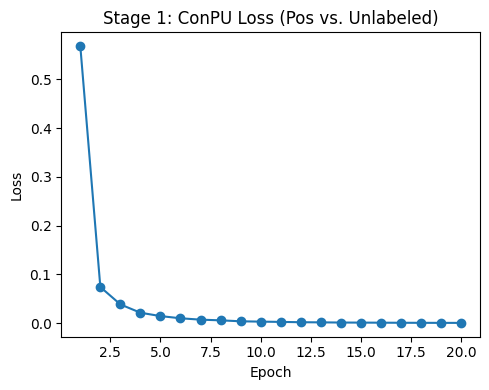

Selected 200 pseudo-negatives out of 6999 unlabeled.
[Stage 2 | Epoch 1/10] Triplet Loss: 6.9979
[Stage 2 | Epoch 2/10] Triplet Loss: 6.9796
[Stage 2 | Epoch 3/10] Triplet Loss: 6.9004
[Stage 2 | Epoch 4/10] Triplet Loss: 6.6797
[Stage 2 | Epoch 5/10] Triplet Loss: 6.0634
[Stage 2 | Epoch 6/10] Triplet Loss: 4.4431
[Stage 2 | Epoch 7/10] Triplet Loss: 2.3198
[Stage 2 | Epoch 8/10] Triplet Loss: 0.7770
[Stage 2 | Epoch 9/10] Triplet Loss: 0.5422
[Stage 2 | Epoch 10/10] Triplet Loss: 0.2477


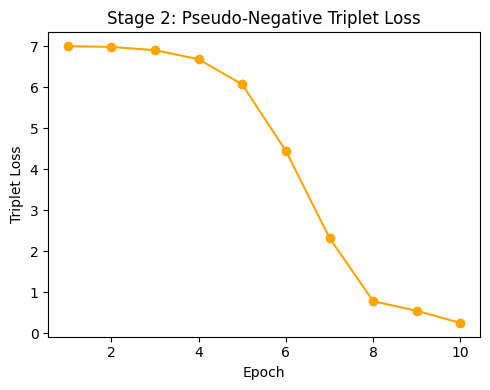

After training:
  ||v₁ − v₀|| = 0.565342903137207
Label distribution in Dᵁ (0=Negative, 1=Positive): {np.int64(0): np.int64(3272), np.int64(1): np.int64(3727)}


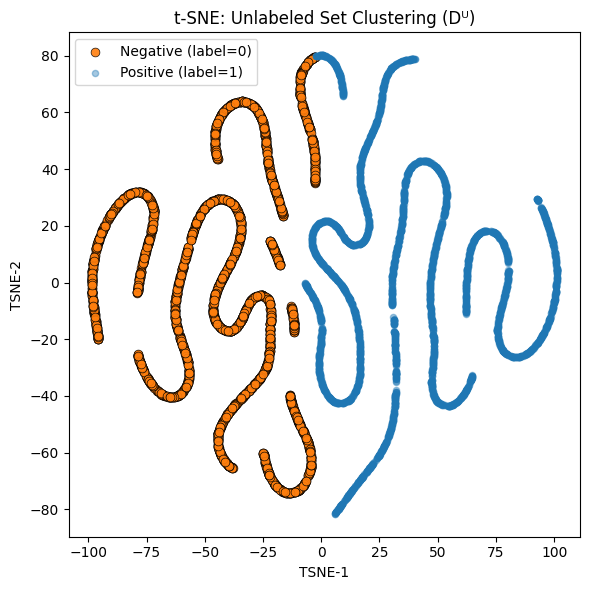

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# -----------------------------------
# 1. LOAD / PREPARE THE RAW DATAFRAME
# -----------------------------------
# (Assume `df` is already in memory, and contains columns "feature_1", ..., "feature_10",
#  a "session_id" column, and a "label" column which is 1.0 for known positives, 0.0 for known negatives,
#  and NaN for unlabeled.)

# 1.1 Extract raw features and labels
feature_cols = [c for c in df.columns if c.startswith("feature_")]
features_raw = df[feature_cols].copy()
labels_raw   = df["label"].copy()

# 1.2 Encode any non-numeric features (none expected, but just in case)
non_numeric_columns = features_raw.select_dtypes(exclude=["number"]).columns
label_encoders = {}
for col in non_numeric_columns:
    le = LabelEncoder()
    features_raw[col] = le.fit_transform(features_raw[col].astype(str))
    label_encoders[col] = le

# 1.3 Fill any NaNs in features with zero (if label encoding introduced NaNs)
features_raw = features_raw.apply(pd.to_numeric, errors="coerce")
features_raw.fillna(0, inplace=True)

# 1.4 Split DataFrame into:
#     - D1_df: all confirmed positives (label == 1.0)
#     - Neg_df: all confirmed negatives (label == 0.0)
#     - Unlabeled_df: all rows where label is NaN
D1_df = df[df["label"] == 1.0].reset_index(drop=True)      # known positives
Neg_df = df[df["label"] == 0.0].reset_index(drop=True)     # known negatives
Unlabeled_df = df[df["label"].isna()].reset_index(drop=True)  # truly unlabeled

print(f"D1 (positives) size:      {len(D1_df)}")
print(f"Neg (known negatives) size:{len(Neg_df)}")
print(f"Unlabeled size:           {len(Unlabeled_df)}")

# 1.5 Extract feature arrays for each set
features_D1 = D1_df[feature_cols].values   # (N_pos, F)
features_Neg = Neg_df[feature_cols].values # (N_neg, F)
features_Unlabeled = Unlabeled_df[feature_cols].values  # (N_unl, F)


# -----------------------------------
# 2. NORMALIZE FEATURES (Zero-Mean, Unit-Variance)
# -----------------------------------
scaler = StandardScaler()
scaler.fit(features_D1)                          # compute mean/scale on positives only

D1_norm = scaler.transform(features_D1)          # (N_pos, F)
Neg_norm = scaler.transform(features_Neg)        # (N_neg, F)
Unlabeled_norm = scaler.transform(features_Unlabeled)  # (N_unl, F)

# Convert to NumPy for convenience
D1 = D1_norm.copy()
Neg = Neg_norm.copy()
Unlabeled = Unlabeled_norm.copy()


# -----------------------------------
# 3. DEFINE THE ENCODER & LOSS FUNCTIONS
# -----------------------------------
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads=4):
        super(MultiHeadSelfAttention, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads)

    def forward(self, x):
        # x: (batch_size, seq_len, hidden_dim)
        x_permuted = x.permute(1, 0, 2)                  # (seq_len, batch_size, hidden_dim)
        attn_out, _ = self.attn(x_permuted, x_permuted, x_permuted)
        # attn_out: (seq_len, batch_size, hidden_dim)
        return attn_out.permute(1, 0, 2).mean(dim=1)     # (batch_size, hidden_dim)


class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.attn = MultiHeadSelfAttention(hidden_dim, num_heads=num_heads)
        self.fc   = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # If x is (batch_size, feature_dim), unsqueeze to (batch_size, 1, feature_dim)
        if x.dim() == 2:
            x = x.unsqueeze(1)  # (batch_size, 1, feature_dim)
        h, _ = self.lstm(x)     # h: (batch_size, seq_len=1, hidden_dim)
        attn_out = self.attn(h) # (batch_size, hidden_dim)
        return self.fc(attn_out)  # (batch_size, output_dim)


# Contrastive PU Loss (same as before)
class KLContrastivePULoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(KLContrastivePULoss, self).__init__()
        self.temperature = temperature
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')

    def forward(self, z_i, z_j, label_indicator, uncertainty_weight):
        # z_i, z_j: (batch_size, output_dim)
        # label_indicator: (batch_size,)  ∈ {0,1}
        # uncertainty_weight: (batch_size,) ≥ 0
        cosine_similarity = nn.CosineSimilarity(dim=-1)
        pos_sim = torch.exp(cosine_similarity(z_i, z_j) / self.temperature)   # (batch_size,)
        neg_sim = (
            torch.exp(cosine_similarity(z_i.unsqueeze(1), z_j.unsqueeze(0)) / self.temperature)
            .sum(dim=-1)
            + 1e-9
        )  # (batch_size,)
        contrastive_term = -torch.log(pos_sim / neg_sim)  # (batch_size,)

        kl_div = self.kl_loss(
            torch.log_softmax(z_i, dim=-1),
            torch.softmax(z_j, dim=-1)
        )  # scalar

        weighted_loss = uncertainty_weight * contrastive_term  # (batch_size,)
        return torch.mean(weighted_loss) + kl_div  # scalar


# Triplet‐style loss for later “negative pushing” (optional)
def triplet_loss_anchor_positive_negative(z_anchor, z_positive, z_negative, margin=1.0):
    """
    A simple triplet loss: enforce
      ||z_anchor - z_positive||^2 + margin  <=  ||z_anchor - z_negative||^2.
    """
    dist_pos = torch.norm(z_anchor - z_positive, dim=1)  # (batch,)
    dist_neg = torch.norm(z_anchor - z_negative, dim=1)  # (batch,)
    loss = F.relu(dist_pos - dist_neg + margin)
    return loss.mean()


# -----------------------------------
# 4. HYPERPARAMETERS & DATALOADERS
# -----------------------------------
input_dim  = D1.shape[1]   # number of features (likely 10)
hidden_dim = 64
output_dim = 32

encoder = LSTMEncoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
contrastive_loss = KLContrastivePULoss(temperature=0.5)

# Convert D1, Neg, and Unlabeled into PyTorch tensors
D1_tensor        = torch.tensor(D1, dtype=torch.float32)            # (N_pos, F)
Neg_tensor       = torch.tensor(Neg, dtype=torch.float32)           # (N_neg, F)
Unlabeled_tensor = torch.tensor(Unlabeled, dtype=torch.float32)     # (N_unl, F)

class SessionDataset(Dataset):
    def __init__(self, data_tensor):
        self.data = data_tensor
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

batch_size = 32
D1_loader        = DataLoader(SessionDataset(D1_tensor), batch_size=batch_size, shuffle=True)
Neg_loader       = DataLoader(SessionDataset(Neg_tensor), batch_size=batch_size, shuffle=True)
Unlabeled_loader = DataLoader(SessionDataset(Unlabeled_tensor), batch_size=batch_size, shuffle=True)


# -----------------------------------
# 5. INITIAL TRAINING LOOP (ConPU on positives vs. unlabeled only)
# -----------------------------------
optimizer = optim.Adam(encoder.parameters(), lr=0.001)
loss_history = []
num_epochs = 20   # you can adjust

for epoch in range(num_epochs):
    encoder.train()
    total_loss = 0.0

    # Compute raw_tau and floor it > 1.0 (ensures v₀ flips to negative side)
    raw_tau = np.std(D1) / np.log(1 + epoch + 1)  # D1 is z-normalized ⇒ std ≈ 1
    tau     = max(raw_tau, 2.0)                   # e.g. floor τ at 2.0
    print(f"[Stage 1 | Epoch {epoch+1}/{num_epochs}] raw_tau = {raw_tau:.4f}, tau = {tau:.4f}")

    for batch_D1, batch_Unlabeled in zip(D1_loader, Unlabeled_loader):
        optimizer.zero_grad()

        # Align batch sizes
        min_bs = min(batch_D1.size(0), batch_Unlabeled.size(0))
        x_pos = batch_D1[:min_bs]         # positives
        x_unl = batch_Unlabeled[:min_bs]  # unlabeled

        z_pos = encoder(x_pos)   # (min_bs, output_dim)
        z_unl = encoder(x_unl)   # (min_bs, output_dim)

        # Compute vᴰ, v₁, v₀
        v_D = torch.mean(z_pos, dim=0)     # (output_dim,)
        v_1 = v_D
        v_0 = (v_D - tau * v_1) / tau       # (output_dim,)

        # Label‐indicator for each unlabeled in the batch
        dist_to_v1 = torch.norm(z_unl - v_1, dim=1)  # (min_bs,)
        dist_to_v0 = torch.norm(z_unl - v_0, dim=1)  # (min_bs,)
        label_indicator = (dist_to_v1 < dist_to_v0).float()

        # Uncertainty weight = ‖z_unl - vᴰ‖_2
        uncertainty_weight = torch.norm(z_unl - v_D, dim=1)

        loss = contrastive_loss(z_pos, z_unl, label_indicator, uncertainty_weight)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    loss_history.append(total_loss)
    print(f"  → Loss: {total_loss:.4f}\n")

# Plot the training loss (Stage 1)
plt.figure(figsize=(5,4))
plt.plot(range(1, num_epochs+1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Stage 1: ConPU Loss (Pos vs. Unlabeled)")
plt.tight_layout()
plt.show()


# -----------------------------------
# 6. PSEUDO-NEGATIVE MINING
# -----------------------------------
# After stage 1, we compute embeddings for all Unlabeled, measure distance from +v_D,
# and pick the top-K farthest as "pseudo-negatives."
encoder.eval()
with torch.no_grad():
    # Compute v_D_all = mean embedding of entire D1 set
    z_D1_all = encoder(D1_tensor)        # (N_pos, output_dim)
    v_D_all  = z_D1_all.mean(dim=0)      # (output_dim,)

    # Encode all unlabeled, compute distance to v_D_all
    z_Unl_all = encoder(Unlabeled_tensor)             # (N_unl, output_dim)
    dist_to_vD = torch.norm(z_Unl_all - v_D_all, dim=1)  # (N_unl,)

    # Pick K farthest unlabeled as pseudo-negatives
    K = 200   # you can tune this number
    farthest_idx = torch.topk(dist_to_vD, k=K).indices.cpu().numpy()
    pseudo_neg_feats = Unlabeled_tensor[farthest_idx]  # (K, feature_dim)

print(f"Selected {K} pseudo-negatives out of {len(Unlabeled)} unlabeled.")


# -----------------------------------
# 7. SECOND TRAINING PHASE (PUSH PSEUDO-NEGATIVES BEHIND)
# -----------------------------------
# We will run a few more epochs where we explicitly push those pseudo-negatives away from v_D_all,
# using a simple triplet-style loss: (anchor=pos, positive=pos, negative=pseudo_neg).
optimizer2 = optim.Adam(encoder.parameters(), lr=0.0005)
triplet_loss_history = []
num_epochs_stage2 = 10

# Create a DataLoader for pseudo-negatives
pseudo_neg_loader = DataLoader(SessionDataset(pseudo_neg_feats), batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs_stage2):
    encoder.train()
    total_t_loss = 0.0

    for (batch_pos, batch_pneg) in zip(D1_loader, pseudo_neg_loader):
        optimizer2.zero_grad()

        # Align batch sizes
        min_bs = min(batch_pos.size(0), batch_pneg.size(0))
        x_pos    = batch_pos[:min_bs]
        x_pneg   = batch_pneg[:min_bs]

        # Forward pass
        z_pos    = encoder(x_pos)    # (min_bs, output_dim)
        z_pos2   = encoder(x_pos)    # use another positive (same batch) as "positive" anchor
        z_pneg   = encoder(x_pneg)   # (min_bs, output_dim)

        # Triplet loss (anchor= z_pos, positive=z_pos2, negative=z_pneg)
        t_loss = triplet_loss_anchor_positive_negative(z_pos, z_pos2, z_pneg, margin=1.0)
        t_loss.backward()
        optimizer2.step()
        total_t_loss += t_loss.item()

    triplet_loss_history.append(total_t_loss)
    print(f"[Stage 2 | Epoch {epoch+1}/{num_epochs_stage2}] Triplet Loss: {total_t_loss:.4f}")

# Plot the triplet loss (Stage 2)
plt.figure(figsize=(5,4))
plt.plot(range(1, num_epochs_stage2+1), triplet_loss_history, marker='o', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Triplet Loss")
plt.title("Stage 2: Pseudo-Negative Triplet Loss")
plt.tight_layout()
plt.show()


# -----------------------------------
# 8. POST-TRAINING: RECOMPUTE v₁, v₀, LABEL COUNTS & t‐SNE
# -----------------------------------
encoder.eval()
with torch.no_grad():
    # 8.1 Recompute v₁ using all positives
    z_D1_all = encoder(D1_tensor)         # (N_pos, output_dim)
    v_1_all  = z_D1_all.mean(dim=0)       # (output_dim,)

    # 8.2 Define v₀ as mean embedding of *both* true negatives and pseudo-negatives
    #     First, encode true negatives:
    z_Neg_all = encoder(Neg_tensor)       # (N_neg, output_dim)
    # Then encode the pseudo-negatives we mined:
    z_PNeg_all = encoder(pseudo_neg_feats)  # (K, output_dim)

    # Combine them to form a single “negative centroid”
    v_0_all = torch.cat([z_Neg_all, z_PNeg_all], dim=0).mean(dim=0)  # (output_dim,)

    print("After training:")
    print("  ||v₁ − v₀|| =", torch.norm(v_1_all - v_0_all).item())

    # 8.3 Compute embeddings for ALL of Dᵁ (unlabeled)
    z_DU_all = encoder(Unlabeled_tensor)           # (N_unl, output_dim)

    # 8.4 Assign pseudo-labels to each unlabeled point
    dist_to_v1 = torch.norm(z_DU_all - v_1_all, dim=1)  # (N_unl,)
    dist_to_v0 = torch.norm(z_DU_all - v_0_all, dim=1)  # (N_unl,)
    labels_tsne = (dist_to_v1 < dist_to_v0).long().cpu().numpy()  # (N_unl,)

# 8.5 Print how many pseudo-positives vs. pseudo-negatives we obtained
unique, counts = np.unique(labels_tsne, return_counts=True)
print("Label distribution in Dᵁ (0=Negative, 1=Positive):", dict(zip(unique, counts)))
# Expected: {0: some >0, 1: some >0}

# 8.6 Run t-SNE on the Dᵁ embeddings (convert to NumPy first)
embeddings_np = z_DU_all.cpu().numpy()  # (N_unl, output_dim)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)  # (N_unl, 2)

# 8.7 Plot, drawing negatives first so they're not hidden
pos_idx = (labels_tsne == 1)
neg_idx = (labels_tsne == 0)

plt.figure(figsize=(6,6))
plt.scatter(
    embeddings_2d[neg_idx, 0],
    embeddings_2d[neg_idx, 1],
    c='tab:orange',
    edgecolor='k',
    linewidth=0.5,
    s=40,
    label='Negative (label=0)',
    alpha=0.9
)
plt.scatter(
    embeddings_2d[pos_idx, 0],
    embeddings_2d[pos_idx, 1],
    c='tab:blue',
    s=20,
    label='Positive (label=1)',
    alpha=0.4
)
plt.legend()
plt.title("t-SNE: Unlabeled Set Clustering (Dᵁ)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.tight_layout()
plt.show()


# t-SNE on validation data

Original sizes:
  D1 (positives):        7470
  Neg (known negatives): 531
  Unlabeled:             6999

After splitting Unlabeled into:
  Unlabeled_train (for ConPU): 5599
  val_df (held-out):          1400
[Stage 1 | Epoch 1/20] raw_tau = 1.4427, tau = 2.0000
  → Stage 1 Loss = 0.4975

[Stage 1 | Epoch 2/20] raw_tau = 0.9102, tau = 2.0000
  → Stage 1 Loss = 0.0703

[Stage 1 | Epoch 3/20] raw_tau = 0.7213, tau = 2.0000
  → Stage 1 Loss = 0.0363

[Stage 1 | Epoch 4/20] raw_tau = 0.6213, tau = 2.0000
  → Stage 1 Loss = 0.0214

[Stage 1 | Epoch 5/20] raw_tau = 0.5581, tau = 2.0000
  → Stage 1 Loss = 0.0145

[Stage 1 | Epoch 6/20] raw_tau = 0.5139, tau = 2.0000
  → Stage 1 Loss = 0.0105

[Stage 1 | Epoch 7/20] raw_tau = 0.4809, tau = 2.0000
  → Stage 1 Loss = 0.0076

[Stage 1 | Epoch 8/20] raw_tau = 0.4551, tau = 2.0000
  → Stage 1 Loss = 0.0059

[Stage 1 | Epoch 9/20] raw_tau = 0.4343, tau = 2.0000
  → Stage 1 Loss = 0.0045

[Stage 1 | Epoch 10/20] raw_tau = 0.4170, tau = 2.0000
  → Sta

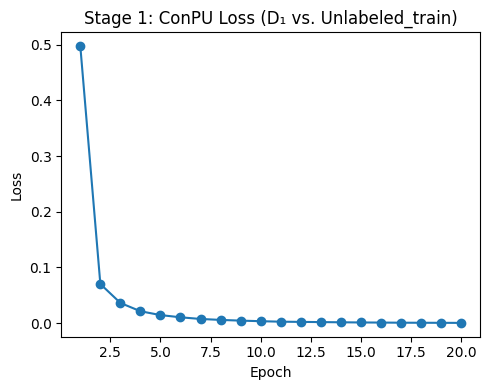

Selected 200 pseudo-negatives from Unlabeled_train.
[Stage 2 | Epoch 1/10] Triplet Loss = 6.9988
[Stage 2 | Epoch 2/10] Triplet Loss = 6.9874
[Stage 2 | Epoch 3/10] Triplet Loss = 6.9463
[Stage 2 | Epoch 4/10] Triplet Loss = 6.8445
[Stage 2 | Epoch 5/10] Triplet Loss = 6.5474
[Stage 2 | Epoch 6/10] Triplet Loss = 5.8570
[Stage 2 | Epoch 7/10] Triplet Loss = 4.2691
[Stage 2 | Epoch 8/10] Triplet Loss = 1.9942
[Stage 2 | Epoch 9/10] Triplet Loss = 0.8351
[Stage 2 | Epoch 10/10] Triplet Loss = 0.5328


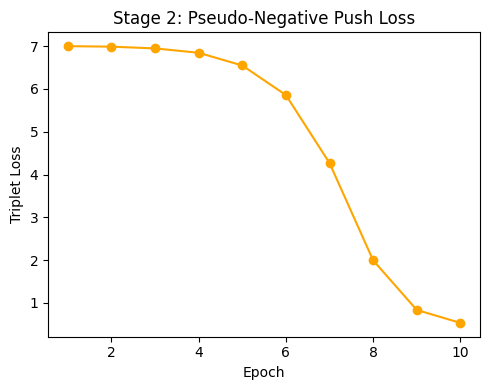


After training:
  ||v₁ – v₀|| = 0.2889094352722168
Unlabeled_train pseudo-labels (0 vs. 1): {np.int64(0): np.int64(3070), np.int64(1): np.int64(2529)}


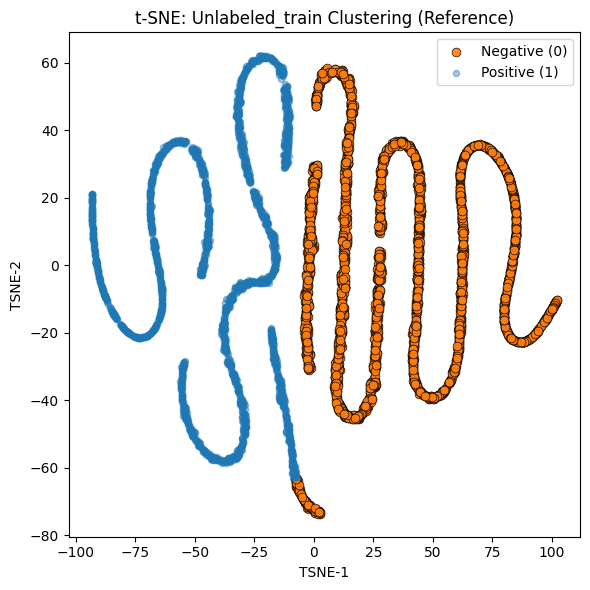


Validation set pseudo-labels (0 vs. 1): {np.int64(0): np.int64(764), np.int64(1): np.int64(636)}


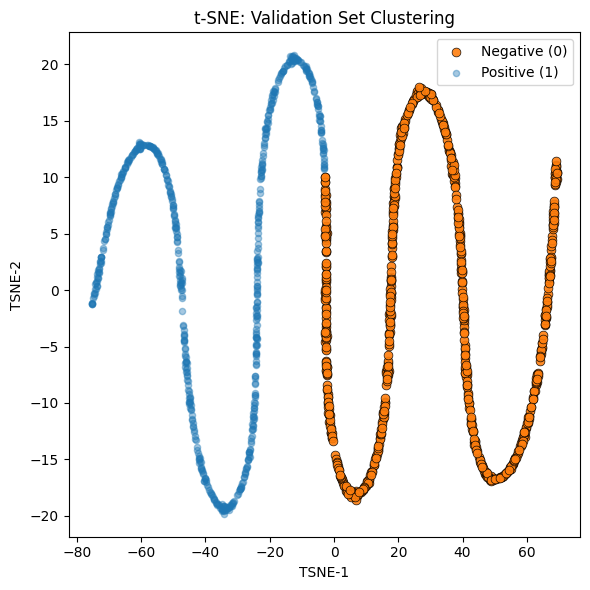

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# -----------------------------------
# STEP 0: SPLIT OFF A VALIDATION SET
# -----------------------------------
# Assume `df` is your full DataFrame with columns:
#   feature_1,...,feature_10, session_id, label (1.0 = positive, 0.0 = negative, NaN = unlabeled).

# 0.1 Separate positives, negatives, unlabeled (as before)
D1_df = df[df["label"] == 1.0].reset_index(drop=True)     # known positives
Neg_df = df[df["label"] == 0.0].reset_index(drop=True)    # known negatives
Unlabeled_df = df[df["label"].isna()].reset_index(drop=True)  # truly unlabeled

print("Original sizes:")
print("  D1 (positives):       ", len(D1_df))
print("  Neg (known negatives):", len(Neg_df))
print("  Unlabeled:            ", len(Unlabeled_df))

# 0.2 From the “Unlabeled_df” pool, hold out 20% as validation, keep 80% for ConPU training.
#     We do a random split with a fixed seed to ensure reproducibility.
unl_train_df, val_df = train_test_split(
    Unlabeled_df,
    test_size=0.20,
    random_state=42,
    shuffle=True
)

print("\nAfter splitting Unlabeled into:")
print("  Unlabeled_train (for ConPU):", len(unl_train_df))
print("  val_df (held-out):         ", len(val_df))


# -----------------------------------
# STEP 1: PREPARE TRAINING SETS (D₁, Negatives, Unlabeled_train)
# -----------------------------------
feature_cols = [c for c in df.columns if c.startswith("feature_")]

# 1.1 Extract feature arrays
features_D1       = D1_df[feature_cols].values            # (N_pos, F)
features_Neg      = Neg_df[feature_cols].values           # (N_neg, F)
features_Unl_train = unl_train_df[feature_cols].values    # (N_unl_train, F)

# 1.2 Encode any non-numeric features (likely none, but just in case)
#     Here we assume feature columns are already numeric, so we skip encoding.

# 1.3 Z‐normalize using only D₁ (positives)
scaler = StandardScaler()
scaler.fit(features_D1)            # fit on positives

D1_norm        = scaler.transform(features_D1)         # (N_pos, F)
Neg_norm       = scaler.transform(features_Neg)        # (N_neg, F)
Unl_train_norm = scaler.transform(features_Unl_train) # (N_unl_train, F)

# Convert to NumPy arrays
D1      = D1_norm.copy()
Neg     = Neg_norm.copy()
Unl_tr  = Unl_train_norm.copy()


# -----------------------------------
# STEP 2: DEFINE ENCODER AND LOSSES
# -----------------------------------
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads=4):
        super(MultiHeadSelfAttention, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads)

    def forward(self, x):
        # x: (batch_size, seq_len, hidden_dim)
        x_permuted = x.permute(1, 0, 2)                   # (seq_len, batch_size, hidden_dim)
        attn_out, _ = self.attn(x_permuted, x_permuted, x_permuted)
        # attn_out: (seq_len, batch_size, hidden_dim)
        return attn_out.permute(1, 0, 2).mean(dim=1)      # (batch_size, hidden_dim)

class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.attn = MultiHeadSelfAttention(hidden_dim, num_heads=num_heads)
        self.fc   = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # If x is (batch_size, feature_dim), add a "seq_len=1" dimension
        if x.dim() == 2:
            x = x.unsqueeze(1)  # (batch_size, 1, feature_dim)
        h, _ = self.lstm(x)     # (batch_size, seq_len, hidden_dim)
        attn_out = self.attn(h) # (batch_size, hidden_dim)
        return self.fc(attn_out)  # (batch_size, output_dim)

class KLContrastivePULoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(KLContrastivePULoss, self).__init__()
        self.temperature = temperature
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')

    def forward(self, z_i, z_j, label_indicator, uncertainty_weight):
        # z_i, z_j: (batch_size, output_dim)
        # label_indicator: (batch_size,) ∈ {0,1}
        # uncertainty_weight: (batch_size,) ≥ 0
        cosine_similarity = nn.CosineSimilarity(dim=-1)
        pos_sim = torch.exp(cosine_similarity(z_i, z_j) / self.temperature)  # (batch_size,)
        neg_sim = (
            torch.exp(cosine_similarity(z_i.unsqueeze(1), z_j.unsqueeze(0)) / self.temperature)
            .sum(dim=-1)
            + 1e-9
        )  # (batch_size,)
        contrastive_term = -torch.log(pos_sim / neg_sim)  # (batch_size,)

        kl_div = self.kl_loss(
            torch.log_softmax(z_i, dim=-1),
            torch.softmax(z_j, dim=-1)
        )  # scalar

        weighted_loss = uncertainty_weight * contrastive_term  # (batch_size,)
        return torch.mean(weighted_loss) + kl_div  # scalar

# Triplet loss to push pseudo-negatives
def triplet_loss_anchor_positive_negative(z_anchor, z_positive, z_negative, margin=1.0):
    dist_pos = torch.norm(z_anchor - z_positive, dim=1)  # (batch,)
    dist_neg = torch.norm(z_anchor - z_negative, dim=1)  # (batch,)
    loss = F.relu(dist_pos - dist_neg + margin)          # (batch,)
    return loss.mean()


# -----------------------------------
# STEP 3: HYPERPARAMETERS & DATALOADERS
# -----------------------------------
input_dim  = D1.shape[1]   # F (number of features, e.g. 10)
hidden_dim = 64
output_dim = 32

encoder = LSTMEncoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
contrastive_loss = KLContrastivePULoss(temperature=0.5)

# Convert D1, Neg, Unl_tr to PyTorch tensors
D1_tensor   = torch.tensor(D1, dtype=torch.float32)       # (N_pos, F)
Neg_tensor  = torch.tensor(Neg, dtype=torch.float32)      # (N_neg, F)
Unl_tr_tensor = torch.tensor(Unl_tr, dtype=torch.float32) # (N_unl_train, F)

class SessionDataset(Dataset):
    def __init__(self, data_tensor):
        self.data = data_tensor
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

batch_size = 32
D1_loader      = DataLoader(SessionDataset(D1_tensor), batch_size=batch_size, shuffle=True)
Neg_loader     = DataLoader(SessionDataset(Neg_tensor), batch_size=batch_size, shuffle=True)
Unl_tr_loader  = DataLoader(SessionDataset(Unl_tr_tensor), batch_size=batch_size, shuffle=True)


# -----------------------------------
# STEP 4: TRAINING, STAGE 1 (ConPU on D₁ vs. Unlabeled_train)
# -----------------------------------
optimizer = optim.Adam(encoder.parameters(), lr=0.001)
loss_history = []
num_epochs = 20  # adjust as needed

for epoch in range(num_epochs):
    encoder.train()
    total_loss = 0.0

    # Compute raw_tau and floor it > 1.0
    raw_tau = np.std(D1) / np.log(1 + epoch + 1)  # D1 is normalized ⇒ std ≈ 1
    tau     = max(raw_tau, 2.0)                   # floor at 2.0 (so v₀ flips negative)
    print(f"[Stage 1 | Epoch {epoch+1}/{num_epochs}] raw_tau = {raw_tau:.4f}, tau = {tau:.4f}")

    for batch_pos, batch_unl in zip(D1_loader, Unl_tr_loader):
        optimizer.zero_grad()

        min_bs = min(batch_pos.size(0), batch_unl.size(0))
        x_pos = batch_pos[:min_bs]
        x_unl = batch_unl[:min_bs]

        z_pos = encoder(x_pos)   # (min_bs, output_dim)
        z_unl = encoder(x_unl)   # (min_bs, output_dim)

        # Compute v_D, v₁, v₀ for this mini-batch
        v_D = torch.mean(z_pos, dim=0)     # (output_dim,)
        v_1 = v_D
        v_0 = (v_D - tau * v_1) / tau       # (output_dim,)

        # Label‐indicator for each unlabeled point in this batch
        dist_to_v1 = torch.norm(z_unl - v_1, dim=1)  # (min_bs,)
        dist_to_v0 = torch.norm(z_unl - v_0, dim=1)  # (min_bs,)
        label_indicator = (dist_to_v1 < dist_to_v0).float()

        # Uncertainty weight
        uncertainty_weight = torch.norm(z_unl - v_D, dim=1)  # (min_bs,)

        loss = contrastive_loss(z_pos, z_unl, label_indicator, uncertainty_weight)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    loss_history.append(total_loss)
    print(f"  → Stage 1 Loss = {total_loss:.4f}\n")

# Plot Stage 1 loss
plt.figure(figsize=(5,4))
plt.plot(range(1, num_epochs+1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Stage 1: ConPU Loss (D₁ vs. Unlabeled_train)")
plt.tight_layout()
plt.show()


# -----------------------------------
# STEP 5: PSEUDO-NEGATIVE MINING FROM Unlabeled_train
# -----------------------------------
encoder.eval()
with torch.no_grad():
    # Compute v_D_all = mean embedding of full D₁ set
    z_D1_all = encoder(D1_tensor)         # (N_pos, output_dim)
    v_D_all  = z_D1_all.mean(dim=0)       # (output_dim,)

    # Compute embeddings for all Unlabeled_train
    z_Unl_tr_all = encoder(Unl_tr_tensor)              # (N_unl_train, output_dim)
    dist_to_vD = torch.norm(z_Unl_tr_all - v_D_all, dim=1)  # (N_unl_train,)

    # Pick the top K farthest as pseudo-negatives
    K = 200
    farthest_idx = torch.topk(dist_to_vD, k=K).indices.cpu().numpy()
    pseudo_neg_feats = Unl_tr_tensor[farthest_idx]    # (K, F)

print(f"Selected {K} pseudo-negatives from Unlabeled_train.")


# -----------------------------------
# STEP 6: TRAINING, STAGE 2 (Push pseudo-negatives)
# -----------------------------------
optimizer2 = optim.Adam(encoder.parameters(), lr=0.0005)
triplet_loss_history = []
num_epochs_stage2 = 10

pseudo_neg_loader = DataLoader(SessionDataset(pseudo_neg_feats), batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs_stage2):
    encoder.train()
    total_triplet_loss = 0.0

    for batch_pos, batch_pneg in zip(D1_loader, pseudo_neg_loader):
        optimizer2.zero_grad()

        min_bs = min(batch_pos.size(0), batch_pneg.size(0))
        x_pos  = batch_pos[:min_bs]
        x_pneg = batch_pneg[:min_bs]

        z_pos  = encoder(x_pos)    # (min_bs, output_dim)
        z_pos2 = encoder(x_pos)    # second positive (same batch) as “positive” anchor
        z_pneg = encoder(x_pneg)   # (min_bs, output_dim)

        t_loss = triplet_loss_anchor_positive_negative(z_pos, z_pos2, z_pneg, margin=1.0)
        t_loss.backward()
        optimizer2.step()
        total_triplet_loss += t_loss.item()

    triplet_loss_history.append(total_triplet_loss)
    print(f"[Stage 2 | Epoch {epoch+1}/{num_epochs_stage2}] Triplet Loss = {total_triplet_loss:.4f}")

# Plot Stage 2 triplet loss
plt.figure(figsize=(5,4))
plt.plot(range(1, num_epochs_stage2+1), triplet_loss_history, marker='o', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Triplet Loss")
plt.title("Stage 2: Pseudo-Negative Push Loss")
plt.tight_layout()
plt.show()


# -----------------------------------
# STEP 7: COMPUTE FINAL CENTROIDS & PSEUDO-LABELS FOR UNLABELED_TRAIN
# -----------------------------------
encoder.eval()
with torch.no_grad():
    # 7.1 Positive centroid v₁ from full D₁:
    z_D1_all = encoder(D1_tensor)       # (N_pos, output_dim)
    v_1_all  = z_D1_all.mean(dim=0)     # (output_dim,)

    # 7.2 Negative centroid v₀ from true Negatives ∪ pseudo-negatives:
    z_Neg_all  = encoder(Neg_tensor)           # (N_neg, output_dim)
    z_PNeg_all = encoder(pseudo_neg_feats)     # (K, output_dim)
    v_0_all    = torch.cat([z_Neg_all, z_PNeg_all], dim=0).mean(dim=0)  # (output_dim,)

    print("\nAfter training:")
    print("  ||v₁ – v₀|| =", torch.norm(v_1_all - v_0_all).item())

    # 7.3 Embed all of Unlabeled_train again:
    z_Unl_tr_all = encoder(Unl_tr_tensor)   # (N_unl_train, output_dim)

    # 7.4 Assign pseudo-labels to Unlabeled_train
    dist_v1_unl = torch.norm(z_Unl_tr_all - v_1_all, dim=1)  # (N_unl_train,)
    dist_v0_unl = torch.norm(z_Unl_tr_all - v_0_all, dim=1)  # (N_unl_train,)
    labels_unl_tsne = (dist_v1_unl < dist_v0_unl).long().cpu().numpy()  # (N_unl_train,)

# 7.5 Print distribution on Unlabeled_train
unique_unl, counts_unl = np.unique(labels_unl_tsne, return_counts=True)
print("Unlabeled_train pseudo-labels (0 vs. 1):", dict(zip(unique_unl, counts_unl)))


# -----------------------------------
# STEP 8: t-SNE ON UNLABELED_TRAIN (FOR REFERENCE)
# -----------------------------------
embeddings_unl_np = z_Unl_tr_all.cpu().numpy()  # (N_unl_train, output_dim)
tsne_unl = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_unl_2d = tsne_unl.fit_transform(embeddings_unl_np)  # (N_unl_train, 2)

pos_idx_unl = (labels_unl_tsne == 1)
neg_idx_unl = (labels_unl_tsne == 0)

plt.figure(figsize=(6,6))
plt.scatter(
    embeddings_unl_2d[neg_idx_unl, 0],
    embeddings_unl_2d[neg_idx_unl, 1],
    c='tab:orange',
    edgecolor='k',
    linewidth=0.5,
    s=40,
    label='Negative (0)',
    alpha=0.9
)
plt.scatter(
    embeddings_unl_2d[pos_idx_unl, 0],
    embeddings_unl_2d[pos_idx_unl, 1],
    c='tab:blue',
    s=20,
    label='Positive (1)',
    alpha=0.4
)
plt.legend()
plt.title("t-SNE: Unlabeled_train Clustering (Reference)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.tight_layout()
plt.show()


# -----------------------------------
# STEP 9: t-SNE ON VALIDATION SET (val_df)
# -----------------------------------
# 9.1 Extract and normalize validation features
features_val = val_df[feature_cols].values  # (N_val, F)
features_val_norm = scaler.transform(features_val)  # (N_val, F)

# 9.2 Compute embeddings for val set
val_tensor = torch.tensor(features_val_norm, dtype=torch.float32)  # (N_val, F)
encoder.eval()
with torch.no_grad():
    z_val_all = encoder(val_tensor)  # (N_val, output_dim)

    # 9.3 Assign pseudo-labels for validation
    dist_v1_val = torch.norm(z_val_all - v_1_all, dim=1)  # (N_val,)
    dist_v0_val = torch.norm(z_val_all - v_0_all, dim=1)  # (N_val,)
    labels_val_tsne = (dist_v1_val < dist_v0_val).long().cpu().numpy()  # (N_val,)

# 9.4 Print validation pseudo-label distribution
unique_val, counts_val = np.unique(labels_val_tsne, return_counts=True)
print("\nValidation set pseudo-labels (0 vs. 1):", dict(zip(unique_val, counts_val)))

# 9.5 Run t-SNE on validation embeddings
embeddings_val_np = z_val_all.cpu().numpy()   # (N_val, output_dim)
tsne_val = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_val_2d = tsne_val.fit_transform(embeddings_val_np)  # (N_val, 2)

pos_idx_val = (labels_val_tsne == 1)
neg_idx_val = (labels_val_tsne == 0)

plt.figure(figsize=(6,6))
plt.scatter(
    embeddings_val_2d[neg_idx_val, 0],
    embeddings_val_2d[neg_idx_val, 1],
    c='tab:orange',
    edgecolor='k',
    linewidth=0.5,
    s=40,
    label='Negative (0)',
    alpha=0.9
)
plt.scatter(
    embeddings_val_2d[pos_idx_val, 0],
    embeddings_val_2d[pos_idx_val, 1],
    c='tab:blue',
    s=20,
    label='Positive (1)',
    alpha=0.4
)
plt.legend()
plt.title("t-SNE: Validation Set Clustering")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.tight_layout()
plt.show()


# Experiment 1: Freezing LSTM Layers and Classification Performance

Original sizes:
  D1 (positives):        7470
  Neg (known negatives): 531
  Unlabeled:             6999

After splitting Unlabeled into:
  Unlabeled_train (for ConPU): 5599
  val_df (held-out):           1400
[Stage 1 | Epoch 1/20] raw_tau = 1.4427, tau = 2.0000
  → Stage 1 Loss = 0.5159

[Stage 1 | Epoch 2/20] raw_tau = 0.9102, tau = 2.0000
  → Stage 1 Loss = 0.0659

[Stage 1 | Epoch 3/20] raw_tau = 0.7213, tau = 2.0000
  → Stage 1 Loss = 0.0345

[Stage 1 | Epoch 4/20] raw_tau = 0.6213, tau = 2.0000
  → Stage 1 Loss = 0.0212

[Stage 1 | Epoch 5/20] raw_tau = 0.5581, tau = 2.0000
  → Stage 1 Loss = 0.0149

[Stage 1 | Epoch 6/20] raw_tau = 0.5139, tau = 2.0000
  → Stage 1 Loss = 0.0097

[Stage 1 | Epoch 7/20] raw_tau = 0.4809, tau = 2.0000
  → Stage 1 Loss = 0.0073

[Stage 1 | Epoch 8/20] raw_tau = 0.4551, tau = 2.0000
  → Stage 1 Loss = 0.0056

[Stage 1 | Epoch 9/20] raw_tau = 0.4343, tau = 2.0000
  → Stage 1 Loss = 0.0045

[Stage 1 | Epoch 10/20] raw_tau = 0.4170, tau = 2.0000
  → St

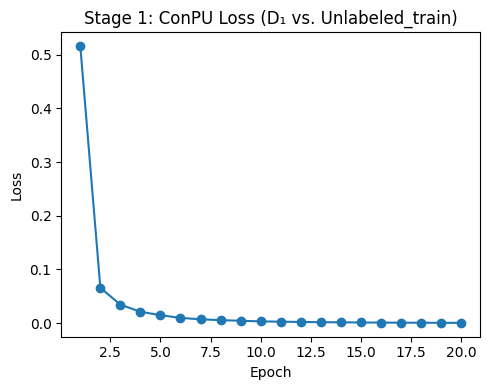

Selected 200 pseudo-negatives from Unlabeled_train.
[Stage 2 | Epoch 1/10] Triplet Loss = 6.9986
[Stage 2 | Epoch 2/10] Triplet Loss = 6.9850
[Stage 2 | Epoch 3/10] Triplet Loss = 6.9354
[Stage 2 | Epoch 4/10] Triplet Loss = 6.7919
[Stage 2 | Epoch 5/10] Triplet Loss = 6.4085
[Stage 2 | Epoch 6/10] Triplet Loss = 5.4250
[Stage 2 | Epoch 7/10] Triplet Loss = 3.3809
[Stage 2 | Epoch 8/10] Triplet Loss = 1.6154
[Stage 2 | Epoch 9/10] Triplet Loss = 0.9012
[Stage 2 | Epoch 10/10] Triplet Loss = 0.4280


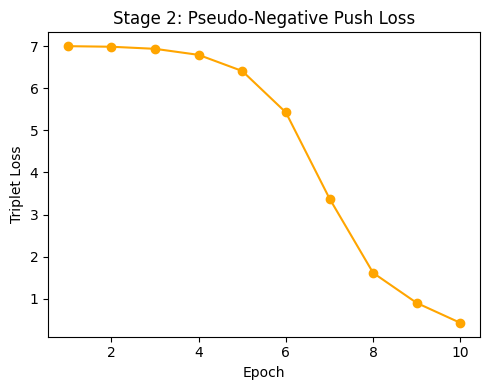


After training:
  ||v₁ – v₀|| = 0.6528533101081848
Unlabeled_train pseudo-labels (0 vs. 1): {np.int64(0): np.int64(2565), np.int64(1): np.int64(3034)}


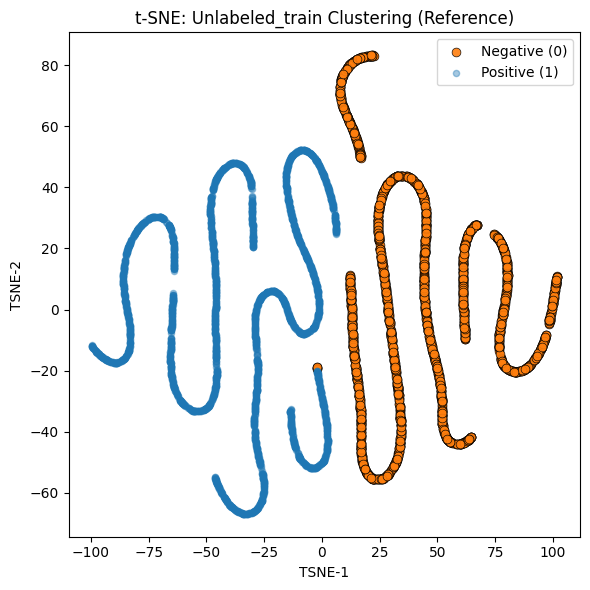


Validation set pseudo-labels (0 vs. 1): {np.int64(0): np.int64(629), np.int64(1): np.int64(771)}


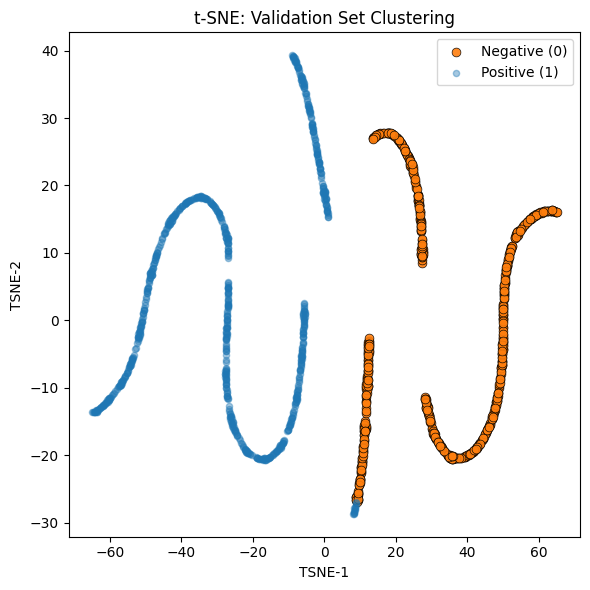


Classifier performance on encoder embeddings:
              Model  Accuracy  Precision  Recall      F1
Logistic Regression   0.93379    0.93379 1.00000 0.96576
      Random Forest   0.90194    0.93668 0.95987 0.94813
                SVM   0.93379    0.93379 1.00000 0.96576
K-Nearest Neighbors   0.93254    0.93371 0.99866 0.96509
        Naive Bayes   0.78763    0.94050 0.82475 0.87883
      Decision Tree   0.88257    0.93596 0.93846 0.93721
  Gradient Boosting   0.93379    0.93433 0.99933 0.96574


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# -----------------------------------
# STEP 0: LOAD / SPLIT OFF A VALIDATION SET
# -----------------------------------
# Assume `df` is already loaded, with columns:
#   feature_1,...,feature_10, session_id, label
# where label == 1.0 → positive, label == 0.0 → negative, label == NaN → unlabeled.

# 0.1 Separate confirmed positives, confirmed negatives, and truly unlabeled
D1_df = df[df["label"] == 1.0].reset_index(drop=True)      # known positives
Neg_df = df[df["label"] == 0.0].reset_index(drop=True)     # known negatives
Unlabeled_df = df[df["label"].isna()].reset_index(drop=True)  # truly unlabeled

print("Original sizes:")
print("  D1 (positives):       ", len(D1_df))
print("  Neg (known negatives):", len(Neg_df))
print("  Unlabeled:            ", len(Unlabeled_df))

# 0.2 From Unlabeled_df, hold out 20% as validation, keep 80% for ConPU training
unl_train_df, val_df = train_test_split(
    Unlabeled_df,
    test_size=0.20,
    random_state=42,
    shuffle=True
)
print("\nAfter splitting Unlabeled into:")
print("  Unlabeled_train (for ConPU):", len(unl_train_df))
print("  val_df (held-out):          ", len(val_df))


# -----------------------------------
# STEP 1: PREPARE TRAINING SETS (D₁, Neg, Unlabeled_train)
# -----------------------------------
feature_cols = [c for c in df.columns if c.startswith("feature_")]

# 1.1 Extract feature arrays
features_D1        = D1_df[feature_cols].values             # (N_pos, F)
features_Neg       = Neg_df[feature_cols].values            # (N_neg, F)
features_Unl_train = unl_train_df[feature_cols].values      # (N_unl_train, F)

# 1.2 Z-normalize using only D₁ (positives)
scaler = StandardScaler()
scaler.fit(features_D1)                     # compute mean/scale on positives

D1_norm        = scaler.transform(features_D1)         # (N_pos, F)
Neg_norm       = scaler.transform(features_Neg)        # (N_neg, F)
Unl_tr_norm    = scaler.transform(features_Unl_train)  # (N_unl_train, F)

# Convert to NumPy arrays
D1      = D1_norm.copy()
Neg     = Neg_norm.copy()
Unl_tr  = Unl_tr_norm.copy()


# -----------------------------------
# STEP 2: DEFINE ENCODER & LOSS FUNCTIONS
# -----------------------------------
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads=4):
        super(MultiHeadSelfAttention, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads)

    def forward(self, x):
        # x: (batch_size, seq_len, hidden_dim)
        x_permuted = x.permute(1, 0, 2)                   # (seq_len, batch_size, hidden_dim)
        attn_out, _ = self.attn(x_permuted, x_permuted, x_permuted)
        # attn_out: (seq_len, batch_size, hidden_dim)
        return attn_out.permute(1, 0, 2).mean(dim=1)      # (batch_size, hidden_dim)

class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.attn = MultiHeadSelfAttention(hidden_dim, num_heads=num_heads)
        self.fc   = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # If x is (batch_size, feature_dim), unsqueeze to (batch_size, 1, feature_dim)
        if x.dim() == 2:
            x = x.unsqueeze(1)  # (batch_size, 1, feature_dim)
        h, _ = self.lstm(x)     # (batch_size, seq_len=1, hidden_dim)
        attn_out = self.attn(h) # (batch_size, hidden_dim)
        return self.fc(attn_out)  # (batch_size, output_dim)

class KLContrastivePULoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(KLContrastivePULoss, self).__init__()
        self.temperature = temperature
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')

    def forward(self, z_i, z_j, label_indicator, uncertainty_weight):
        cosine_similarity = nn.CosineSimilarity(dim=-1)
        pos_sim = torch.exp(cosine_similarity(z_i, z_j) / self.temperature)   # (batch_size,)
        neg_sim = (
            torch.exp(cosine_similarity(z_i.unsqueeze(1), z_j.unsqueeze(0)) / self.temperature)
            .sum(dim=-1)
            + 1e-9
        )  # (batch_size,)
        contrastive_term = -torch.log(pos_sim / neg_sim)  # (batch_size,)

        kl_div = self.kl_loss(
            torch.log_softmax(z_i, dim=-1),
            torch.softmax(z_j, dim=-1)
        )  # scalar

        weighted_loss = uncertainty_weight * contrastive_term  # (batch_size,)
        return torch.mean(weighted_loss) + kl_div  # scalar

def triplet_loss_anchor_positive_negative(z_anchor, z_positive, z_negative, margin=1.0):
    dist_pos = torch.norm(z_anchor - z_positive, dim=1)  # (batch,)
    dist_neg = torch.norm(z_anchor - z_negative, dim=1)  # (batch,)
    loss = F.relu(dist_pos - dist_neg + margin)          # (batch,)
    return loss.mean()


# -----------------------------------
# STEP 3: HYPERPARAMETERS & DATALOADERS
# -----------------------------------
input_dim  = D1.shape[1]   # number of features, e.g. 10
hidden_dim = 64
output_dim = 32

encoder = LSTMEncoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
contrastive_loss = KLContrastivePULoss(temperature=0.5)

# Convert D1, Neg, Unl_tr to PyTorch tensors
D1_tensor    = torch.tensor(D1, dtype=torch.float32)     # (N_pos, F)
Neg_tensor   = torch.tensor(Neg, dtype=torch.float32)    # (N_neg, F)
Unl_tr_tensor= torch.tensor(Unl_tr, dtype=torch.float32) # (N_unl_train, F)

class SessionDataset(Dataset):
    def __init__(self, data_tensor):
        self.data = data_tensor
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

batch_size = 32
D1_loader     = DataLoader(SessionDataset(D1_tensor), batch_size=batch_size, shuffle=True)
Neg_loader    = DataLoader(SessionDataset(Neg_tensor), batch_size=batch_size, shuffle=True)
Unl_tr_loader = DataLoader(SessionDataset(Unl_tr_tensor), batch_size=batch_size, shuffle=True)


# -----------------------------------
# STEP 4: TRAINING, STAGE 1 (ConPU on D₁ vs. Unlabeled_train)
# -----------------------------------
optimizer = optim.Adam(encoder.parameters(), lr=0.001)
loss_history = []
num_epochs = 20

for epoch in range(num_epochs):
    encoder.train()
    total_loss = 0.0

    # Compute raw_tau and floor it > 1.0 (so v₀ flips negative)
    raw_tau = np.std(D1) / np.log(1 + epoch + 1)  # D1 is normalized ⇒ std ≈ 1
    tau     = max(raw_tau, 2.0)                   # floor at 2.0
    print(f"[Stage 1 | Epoch {epoch+1}/{num_epochs}] raw_tau = {raw_tau:.4f}, tau = {tau:.4f}")

    for batch_pos, batch_unl in zip(D1_loader, Unl_tr_loader):
        optimizer.zero_grad()
        min_bs = min(batch_pos.size(0), batch_unl.size(0))
        x_pos = batch_pos[:min_bs]
        x_unl = batch_unl[:min_bs]

        z_pos = encoder(x_pos)   # (min_bs, output_dim)
        z_unl = encoder(x_unl)   # (min_bs, output_dim)

        # Compute v_D, v₁, v₀
        v_D = torch.mean(z_pos, dim=0)     # (output_dim,)
        v_1 = v_D
        v_0 = (v_D - tau * v_1) / tau       # (output_dim,)

        # Label-indicator for each unlabeled in this batch
        dist_to_v1 = torch.norm(z_unl - v_1, dim=1)  # (min_bs,)
        dist_to_v0 = torch.norm(z_unl - v_0, dim=1)  # (min_bs,)
        label_indicator = (dist_to_v1 < dist_to_v0).float()

        # Uncertainty weight
        uncertainty_weight = torch.norm(z_unl - v_D, dim=1)  # (min_bs,)

        loss = contrastive_loss(z_pos, z_unl, label_indicator, uncertainty_weight)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    loss_history.append(total_loss)
    print(f"  → Stage 1 Loss = {total_loss:.4f}\n")

# Plot Stage 1 loss
plt.figure(figsize=(5,4))
plt.plot(range(1, num_epochs+1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Stage 1: ConPU Loss (D₁ vs. Unlabeled_train)")
plt.tight_layout()
plt.show()


# -----------------------------------
# STEP 5: PSEUDO-NEGATIVE MINING FROM Unlabeled_train
# -----------------------------------
encoder.eval()
with torch.no_grad():
    # Compute v_D_all = mean embedding of all D₁
    z_D1_all = encoder(D1_tensor)        # (N_pos, output_dim)
    v_D_all  = z_D1_all.mean(dim=0)      # (output_dim,)

    # Compute embeddings for Unlabeled_train
    z_Unl_tr_all = encoder(Unl_tr_tensor)               # (N_unl_train, output_dim)
    dist_to_vD = torch.norm(z_Unl_tr_all - v_D_all, dim=1)  # (N_unl_train,)

    # Pick top K farthest as pseudo-negatives
    K = 200
    farthest_idx = torch.topk(dist_to_vD, k=K).indices.cpu().numpy()
    pseudo_neg_feats = Unl_tr_tensor[farthest_idx]    # (K, F)

print(f"Selected {K} pseudo-negatives from Unlabeled_train.")


# -----------------------------------
# STEP 6: TRAINING, STAGE 2 (Push pseudo-negatives)
# -----------------------------------
optimizer2 = optim.Adam(encoder.parameters(), lr=0.0005)
triplet_loss_history = []
num_epochs_stage2 = 10

pseudo_neg_loader = DataLoader(SessionDataset(pseudo_neg_feats), batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs_stage2):
    encoder.train()
    total_triplet_loss = 0.0

    for batch_pos, batch_pneg in zip(D1_loader, pseudo_neg_loader):
        optimizer2.zero_grad()
        min_bs = min(batch_pos.size(0), batch_pneg.size(0))
        x_pos  = batch_pos[:min_bs]
        x_pneg = batch_pneg[:min_bs]

        z_pos  = encoder(x_pos)    # (min_bs, output_dim)
        z_pos2 = encoder(x_pos)    # second positive as “positive” anchor
        z_pneg = encoder(x_pneg)   # (min_bs, output_dim)

        t_loss = triplet_loss_anchor_positive_negative(z_pos, z_pos2, z_pneg, margin=1.0)
        t_loss.backward()
        optimizer2.step()
        total_triplet_loss += t_loss.item()

    triplet_loss_history.append(total_triplet_loss)
    print(f"[Stage 2 | Epoch {epoch+1}/{num_epochs_stage2}] Triplet Loss = {total_triplet_loss:.4f}")

# Plot Stage 2 triplet loss
plt.figure(figsize=(5,4))
plt.plot(range(1, num_epochs_stage2+1), triplet_loss_history, marker='o', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Triplet Loss")
plt.title("Stage 2: Pseudo-Negative Push Loss")
plt.tight_layout()
plt.show()


# -----------------------------------
# STEP 7: COMPUTE FINAL CENTROIDS & PSEUDO-LABELS FOR Unlabeled_train
# -----------------------------------
encoder.eval()
with torch.no_grad():
    # 7.1 Positive centroid v₁ from all D₁
    z_D1_all = encoder(D1_tensor)       # (N_pos, output_dim)
    v_1_all  = z_D1_all.mean(dim=0)     # (output_dim,)

    # 7.2 Negative centroid v₀ from true Negatives ∪ pseudo-negatives
    z_Neg_all  = encoder(Neg_tensor)           # (N_neg, output_dim)
    z_PNeg_all = encoder(pseudo_neg_feats)     # (K, output_dim)
    v_0_all    = torch.cat([z_Neg_all, z_PNeg_all], dim=0).mean(dim=0)  # (output_dim,)

    print("\nAfter training:")
    print("  ||v₁ – v₀|| =", torch.norm(v_1_all - v_0_all).item())

    # 7.3 Embed all of Unlabeled_train again
    z_Unl_tr_all = encoder(Unl_tr_tensor)   # (N_unl_train, output_dim)

    # 7.4 Assign pseudo-labels to Unlabeled_train
    dist_v1_unl = torch.norm(z_Unl_tr_all - v_1_all, dim=1)  # (N_unl_train,)
    dist_v0_unl = torch.norm(z_Unl_tr_all - v_0_all, dim=1)  # (N_unl_train,)
    labels_unl_tsne = (dist_v1_unl < dist_v0_unl).long().cpu().numpy()  # (N_unl_train,)

# 7.5 Print distribution on Unlabeled_train
unique_unl, counts_unl = np.unique(labels_unl_tsne, return_counts=True)
print("Unlabeled_train pseudo-labels (0 vs. 1):", dict(zip(unique_unl, counts_unl)))


# -----------------------------------
# STEP 8: t-SNE ON Unlabeled_train (REFERENCE)
# -----------------------------------
embeddings_unl_np = z_Unl_tr_all.cpu().numpy()  # (N_unl_train, output_dim)
tsne_unl = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_unl_2d = tsne_unl.fit_transform(embeddings_unl_np)  # (N_unl_train, 2)

pos_idx_unl = (labels_unl_tsne == 1)
neg_idx_unl = (labels_unl_tsne == 0)

plt.figure(figsize=(6,6))
plt.scatter(
    embeddings_unl_2d[neg_idx_unl, 0],
    embeddings_unl_2d[neg_idx_unl, 1],
    c='tab:orange',
    edgecolor='k',
    linewidth=0.5,
    s=40,
    label='Negative (0)',
    alpha=0.9
)
plt.scatter(
    embeddings_unl_2d[pos_idx_unl, 0],
    embeddings_unl_2d[pos_idx_unl, 1],
    c='tab:blue',
    s=20,
    label='Positive (1)',
    alpha=0.4
)
plt.legend()
plt.title("t-SNE: Unlabeled_train Clustering (Reference)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.tight_layout()
plt.show()


# -----------------------------------
# STEP 9: t-SNE ON VALIDATION SET (val_df)
# -----------------------------------
features_val = val_df[feature_cols].values      # (N_val, F)
features_val_norm = scaler.transform(features_val)  # (N_val, F)

val_tensor = torch.tensor(features_val_norm, dtype=torch.float32)  # (N_val, F)
encoder.eval()
with torch.no_grad():
    z_val_all = encoder(val_tensor)  # (N_val, output_dim)

    dist_v1_val = torch.norm(z_val_all - v_1_all, dim=1)  # (N_val,)
    dist_v0_val = torch.norm(z_val_all - v_0_all, dim=1)  # (N_val,)
    labels_val_tsne = (dist_v1_val < dist_v0_val).long().cpu().numpy()  # (N_val,)

unique_val, counts_val = np.unique(labels_val_tsne, return_counts=True)
print("\nValidation set pseudo-labels (0 vs. 1):", dict(zip(unique_val, counts_val)))

embeddings_val_np = z_val_all.cpu().numpy()  # (N_val, output_dim)
tsne_val = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_val_2d = tsne_val.fit_transform(embeddings_val_np)  # (N_val, 2)

pos_idx_val = (labels_val_tsne == 1)
neg_idx_val = (labels_val_tsne == 0)

plt.figure(figsize=(6,6))
plt.scatter(
    embeddings_val_2d[neg_idx_val, 0],
    embeddings_val_2d[neg_idx_val, 1],
    c='tab:orange',
    edgecolor='k',
    linewidth=0.5,
    s=40,
    label='Negative (0)',
    alpha=0.9
)
plt.scatter(
    embeddings_val_2d[pos_idx_val, 0],
    embeddings_val_2d[pos_idx_val, 1],
    c='tab:blue',
    s=20,
    label='Positive (1)',
    alpha=0.4
)
plt.legend()
plt.title("t-SNE: Validation Set Clustering")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.tight_layout()
plt.show()


# -----------------------------------
# STEP 10: FREEZE ENCODER & EXTRACT EMBEDDINGS FOR CLASSIFICATION
# -----------------------------------
encoder.eval()
with torch.no_grad():
    # Combine D₁ (positives) and Neg (negatives) into a labeled dataset
    X_pos = D1_norm            # (N_pos, F)
    X_neg = Neg_norm           # (N_neg, F)
    y_pos = np.ones(len(X_pos), dtype=int)
    y_neg = np.zeros(len(X_neg), dtype=int)

    X_all = np.vstack([X_pos, X_neg])  # (N_pos+N_neg, F)
    y_all = np.concatenate([y_pos, y_neg])  # (N_pos+N_neg,)

    # Convert to torch and compute embeddings via frozen encoder
    X_all_tensor = torch.tensor(X_all, dtype=torch.float32)  # (N_all, F)
    Z_all = encoder(X_all_tensor).cpu().numpy()              # (N_all, output_dim)

# 10.1 Split embeddings into train/test for downstream classifiers
X_train, X_test, y_train, y_test = train_test_split(
    Z_all, y_all, test_size=0.20, random_state=42, stratify=y_all
)

# 10.2 Define a list of sklearn classifiers to evaluate
classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("SVM", SVC(kernel="rbf", probability=True, random_state=42)),
    ("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=5)),
    ("Naive Bayes", GaussianNB()),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# 10.3 Train each classifier and compute metrics on the test set
results = []
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    results.append((name, acc, prec, rec, f1))

# 10.4 Display results in a DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
print("\nClassifier performance on encoder embeddings:")
print(results_df.to_string(index=False, float_format='{:.5f}'.format))


# Experiment 2: Freezing LSTM Layers and Classification Performance with Hyperparameter Tuning

Original sizes:
  D1 (positives):        7470
  Neg (known negatives): 531
  Unlabeled:             6999

After splitting Unlabeled:
  Unlabeled_train (ConPU): 5599
  val_df (held-out):        1400
[Stage 1 | Epoch 1/20] raw_tau = 1.4427, tau = 2.0000
  → Stage 1 Loss = 0.4653

[Stage 1 | Epoch 2/20] raw_tau = 0.9102, tau = 2.0000
  → Stage 1 Loss = 0.0651

[Stage 1 | Epoch 3/20] raw_tau = 0.7213, tau = 2.0000
  → Stage 1 Loss = 0.0329

[Stage 1 | Epoch 4/20] raw_tau = 0.6213, tau = 2.0000
  → Stage 1 Loss = 0.0197

[Stage 1 | Epoch 5/20] raw_tau = 0.5581, tau = 2.0000
  → Stage 1 Loss = 0.0133

[Stage 1 | Epoch 6/20] raw_tau = 0.5139, tau = 2.0000
  → Stage 1 Loss = 0.0095

[Stage 1 | Epoch 7/20] raw_tau = 0.4809, tau = 2.0000
  → Stage 1 Loss = 0.0074

[Stage 1 | Epoch 8/20] raw_tau = 0.4551, tau = 2.0000
  → Stage 1 Loss = 0.0053

[Stage 1 | Epoch 9/20] raw_tau = 0.4343, tau = 2.0000
  → Stage 1 Loss = 0.0041

[Stage 1 | Epoch 10/20] raw_tau = 0.4170, tau = 2.0000
  → Stage 1 Loss =

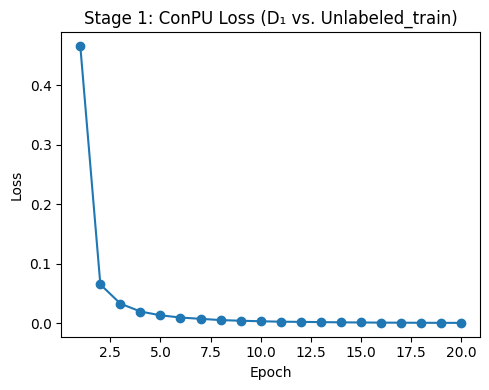

Selected 200 pseudo-negatives from Unlabeled_train.
[Stage 2 | Epoch 1/10] Triplet Loss = 6.9981
[Stage 2 | Epoch 2/10] Triplet Loss = 6.9809
[Stage 2 | Epoch 3/10] Triplet Loss = 6.9113
[Stage 2 | Epoch 4/10] Triplet Loss = 6.7609
[Stage 2 | Epoch 5/10] Triplet Loss = 6.3246
[Stage 2 | Epoch 6/10] Triplet Loss = 5.0840
[Stage 2 | Epoch 7/10] Triplet Loss = 2.9213
[Stage 2 | Epoch 8/10] Triplet Loss = 1.4426
[Stage 2 | Epoch 9/10] Triplet Loss = 1.1367
[Stage 2 | Epoch 10/10] Triplet Loss = 0.5691


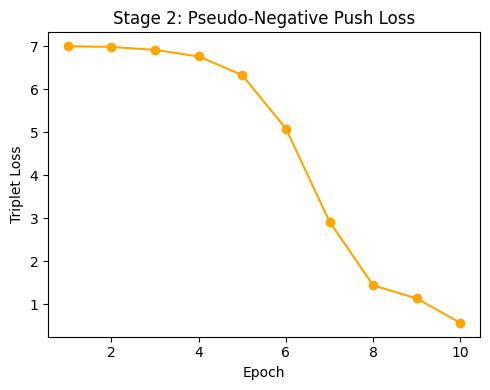


After training:
  ||v₁ – v₀|| = 2.1467244625091553
Unlabeled_train pseudo-labels (0 vs. 1): {np.int64(0): np.int64(4045), np.int64(1): np.int64(1554)}


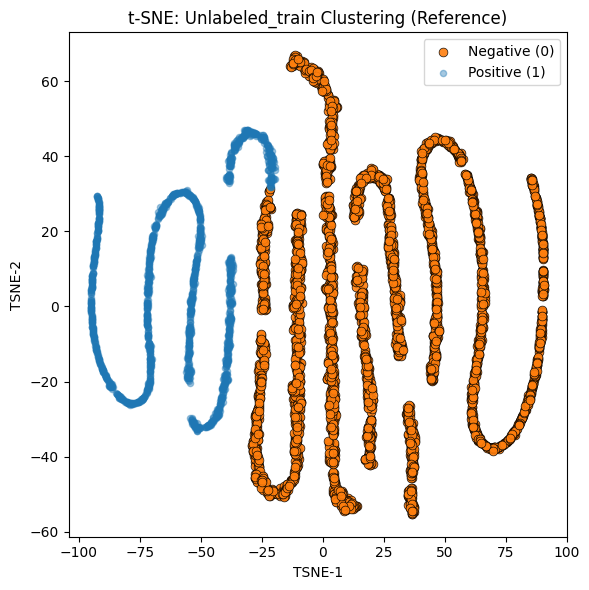


Validation set pseudo-labels (0 vs. 1): {np.int64(0): np.int64(1017), np.int64(1): np.int64(383)}


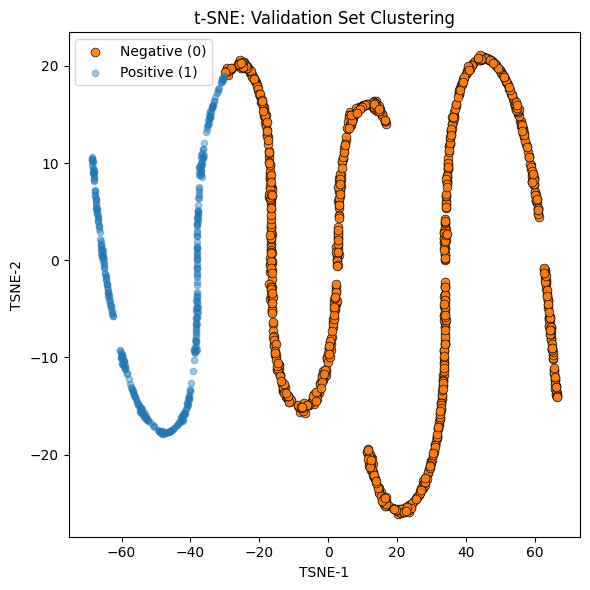


Initial classifier performance on encoder embeddings:
              Model  Accuracy  Precision  Recall      F1
Logistic Regression   0.93379    0.93379 1.00000 0.96576
      Random Forest   0.91755    0.93602 0.97860 0.95683
                SVM   0.93379    0.93379 1.00000 0.96576
K-Nearest Neighbors   0.92879    0.93400 0.99398 0.96306
        Naive Bayes   0.59338    0.98064 0.57592 0.72566
      Decision Tree   0.87883    0.93982 0.92977 0.93477
  Gradient Boosting   0.93254    0.93425 0.99799 0.96507

Five‐Fold CV results on encoder embeddings:
              Model  CV_Accuracy  CV_Precision  CV_Recall   CV_F1
Logistic Regression      0.93363       0.93363    1.00000 0.96568
      Random Forest      0.91776       0.93578    0.97912 0.95695
                SVM      0.93363       0.93363    1.00000 0.96568
K-Nearest Neighbors      0.92826       0.93415    0.99317 0.96276
        Naive Bayes      0.59680       0.97708    0.58179 0.72931
      Decision Tree      0.88026       0.93775  

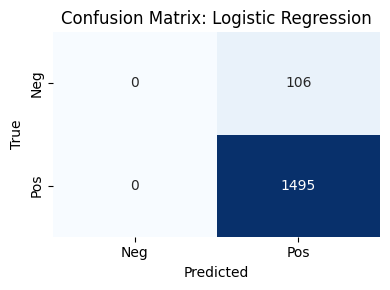

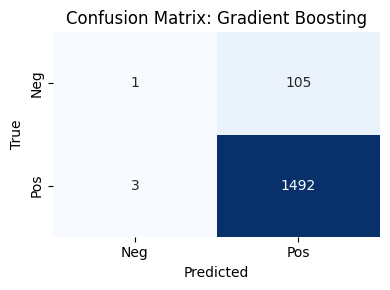

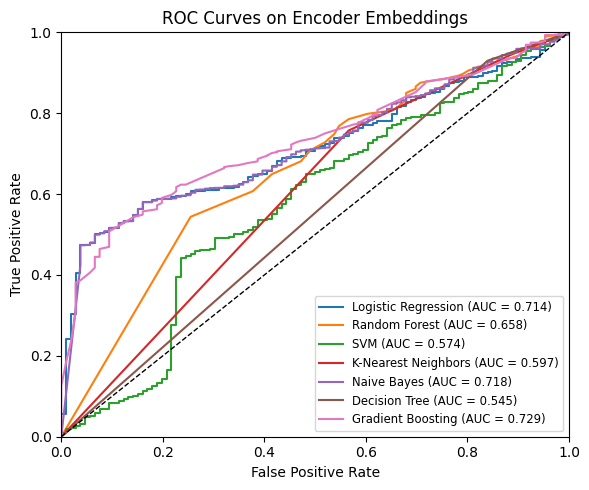

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc
)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns  # for confusion‐matrix heatmaps

# -----------------------------------
# STEP 0: LOAD / SPLIT OFF A VALIDATION SET
# -----------------------------------
# Assume df is already loaded with columns:
#   feature_1 ... feature_10, session_id, label (1.0=positive, 0.0=negative, NaN=unlabeled).

# 0.1 Separate confirmed positives, negatives, and unlabeled
D1_df = df[df["label"] == 1.0].reset_index(drop=True)
Neg_df = df[df["label"] == 0.0].reset_index(drop=True)
Unlabeled_df = df[df["label"].isna()].reset_index(drop=True)

print("Original sizes:")
print("  D1 (positives):       ", len(D1_df))
print("  Neg (known negatives):", len(Neg_df))
print("  Unlabeled:            ", len(Unlabeled_df))

# 0.2 Split Unlabeled into train‐unlabeled (80%) and held‐out validation (20%)
unl_train_df, val_df = train_test_split(
    Unlabeled_df,
    test_size=0.20,
    random_state=42,
    shuffle=True
)
print("\nAfter splitting Unlabeled:")
print("  Unlabeled_train (ConPU):", len(unl_train_df))
print("  val_df (held-out):       ", len(val_df))


# -----------------------------------
# STEP 1: PREPARE TRAINING SETS (D₁, Neg, Unlabeled_train)
# -----------------------------------
feature_cols = [c for c in df.columns if c.startswith("feature_")]

# 1.1 Extract feature arrays
features_D1        = D1_df[feature_cols].values
features_Neg       = Neg_df[feature_cols].values
features_Unl_train = unl_train_df[feature_cols].values

# 1.2 Z-normalize using only D₁
scaler = StandardScaler()
scaler.fit(features_D1)

D1_norm        = scaler.transform(features_D1)
Neg_norm       = scaler.transform(features_Neg)
Unl_tr_norm    = scaler.transform(features_Unl_train)

D1      = D1_norm.copy()
Neg     = Neg_norm.copy()
Unl_tr  = Unl_tr_norm.copy()


# -----------------------------------
# STEP 2: DEFINE ENCODER & LOSS
# -----------------------------------
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads=4):
        super(MultiHeadSelfAttention, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads)

    def forward(self, x):
        # x: (batch_size, seq_len, hidden_dim)
        x_permuted = x.permute(1, 0, 2)
        attn_out, _ = self.attn(x_permuted, x_permuted, x_permuted)
        return attn_out.permute(1, 0, 2).mean(dim=1)  # (batch_size, hidden_dim)

class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.attn = MultiHeadSelfAttention(hidden_dim, num_heads=num_heads)
        self.fc   = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # If x is (batch_size, feature_dim), unsqueeze to (batch_size, 1, feature_dim)
        if x.dim() == 2:
            x = x.unsqueeze(1)  # (batch_size, 1, feature_dim)
        h, _ = self.lstm(x)
        attn_out = self.attn(h)
        return self.fc(attn_out)  # (batch_size, output_dim)

class KLContrastivePULoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(KLContrastivePULoss, self).__init__()
        self.temperature = temperature
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')

    def forward(self, z_i, z_j, label_indicator, uncertainty_weight):
        cosine_similarity = nn.CosineSimilarity(dim=-1)
        pos_sim = torch.exp(cosine_similarity(z_i, z_j) / self.temperature)
        neg_sim = (
            torch.exp(cosine_similarity(z_i.unsqueeze(1), z_j.unsqueeze(0)) / self.temperature)
            .sum(dim=-1) + 1e-9
        )
        contrastive_term = -torch.log(pos_sim / neg_sim)
        kl_div = self.kl_loss(torch.log_softmax(z_i, dim=-1), torch.softmax(z_j, dim=-1))
        weighted_loss = uncertainty_weight * contrastive_term
        return torch.mean(weighted_loss) + kl_div

def triplet_loss_anchor_positive_negative(z_anchor, z_positive, z_negative, margin=1.0):
    dist_pos = torch.norm(z_anchor - z_positive, dim=1)
    dist_neg = torch.norm(z_anchor - z_negative, dim=1)
    loss = F.relu(dist_pos - dist_neg + margin)
    return loss.mean()


# -----------------------------------
# STEP 3: HYPERPARAMETERS & DATALOADERS
# -----------------------------------
input_dim  = D1.shape[1]  # number of features
hidden_dim = 64
output_dim = 32

encoder = LSTMEncoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
contrastive_loss = KLContrastivePULoss(temperature=0.5)

D1_tensor     = torch.tensor(D1, dtype=torch.float32)
Neg_tensor    = torch.tensor(Neg, dtype=torch.float32)
Unl_tr_tensor = torch.tensor(Unl_tr, dtype=torch.float32)

class SessionDataset(Dataset):
    def __init__(self, data_tensor):
        self.data = data_tensor
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

batch_size = 32
D1_loader      = DataLoader(SessionDataset(D1_tensor), batch_size=batch_size, shuffle=True)
Neg_loader     = DataLoader(SessionDataset(Neg_tensor), batch_size=batch_size, shuffle=True)
Unl_tr_loader  = DataLoader(SessionDataset(Unl_tr_tensor), batch_size=batch_size, shuffle=True)


# -----------------------------------
# STEP 4: TRAINING, STAGE 1 (ConPU on D₁ vs. Unlabeled_train)
# -----------------------------------
optimizer = optim.Adam(encoder.parameters(), lr=0.001)
loss_history = []
num_epochs = 20

for epoch in range(num_epochs):
    encoder.train()
    total_loss = 0.0

    raw_tau = np.std(D1) / np.log(1 + epoch + 1)
    tau     = max(raw_tau, 2.0)
    print(f"[Stage 1 | Epoch {epoch+1}/{num_epochs}] raw_tau = {raw_tau:.4f}, tau = {tau:.4f}")

    for batch_pos, batch_unl in zip(D1_loader, Unl_tr_loader):
        optimizer.zero_grad()
        min_bs = min(batch_pos.size(0), batch_unl.size(0))
        x_pos = batch_pos[:min_bs]
        x_unl = batch_unl[:min_bs]

        z_pos = encoder(x_pos)
        z_unl = encoder(x_unl)

        v_D = torch.mean(z_pos, dim=0)
        v_1 = v_D
        v_0 = (v_D - tau * v_1) / tau

        dist_to_v1 = torch.norm(z_unl - v_1, dim=1)
        dist_to_v0 = torch.norm(z_unl - v_0, dim=1)
        label_indicator = (dist_to_v1 < dist_to_v0).float()

        uncertainty_weight = torch.norm(z_unl - v_D, dim=1)

        loss = contrastive_loss(z_pos, z_unl, label_indicator, uncertainty_weight)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    loss_history.append(total_loss)
    print(f"  → Stage 1 Loss = {total_loss:.4f}\n")

# Plot Stage 1 loss
plt.figure(figsize=(5,4))
plt.plot(range(1, num_epochs+1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Stage 1: ConPU Loss (D₁ vs. Unlabeled_train)")
plt.tight_layout()
plt.show()


# -----------------------------------
# STEP 5: PSEUDO-NEGATIVE MINING FROM Unlabeled_train
# -----------------------------------
encoder.eval()
with torch.no_grad():
    z_D1_all = encoder(D1_tensor)
    v_D_all  = z_D1_all.mean(dim=0)

    z_Unl_tr_all = encoder(Unl_tr_tensor)
    dist_to_vD = torch.norm(z_Unl_tr_all - v_D_all, dim=1)

    K = 200
    farthest_idx = torch.topk(dist_to_vD, k=K).indices.cpu().numpy()
    pseudo_neg_feats = Unl_tr_tensor[farthest_idx]

print(f"Selected {K} pseudo-negatives from Unlabeled_train.")


# -----------------------------------
# STEP 6: TRAINING, STAGE 2 (Push pseudo-negatives)
# -----------------------------------
optimizer2 = optim.Adam(encoder.parameters(), lr=0.0005)
triplet_loss_history = []
num_epochs_stage2 = 10

pseudo_neg_loader = DataLoader(SessionDataset(pseudo_neg_feats), batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs_stage2):
    encoder.train()
    total_triplet_loss = 0.0

    for batch_pos, batch_pneg in zip(D1_loader, pseudo_neg_loader):
        optimizer2.zero_grad()
        min_bs = min(batch_pos.size(0), batch_pneg.size(0))
        x_pos  = batch_pos[:min_bs]
        x_pneg = batch_pneg[:min_bs]

        z_pos  = encoder(x_pos)
        z_pos2 = encoder(x_pos)
        z_pneg = encoder(x_pneg)

        t_loss = triplet_loss_anchor_positive_negative(z_pos, z_pos2, z_pneg, margin=1.0)
        t_loss.backward()
        optimizer2.step()
        total_triplet_loss += t_loss.item()

    triplet_loss_history.append(total_triplet_loss)
    print(f"[Stage 2 | Epoch {epoch+1}/{num_epochs_stage2}] Triplet Loss = {total_triplet_loss:.4f}")

# Plot Stage 2 triplet loss
plt.figure(figsize=(5,4))
plt.plot(range(1, num_epochs_stage2+1), triplet_loss_history, marker='o', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Triplet Loss")
plt.title("Stage 2: Pseudo-Negative Push Loss")
plt.tight_layout()
plt.show()


# -----------------------------------
# STEP 7: COMPUTE FINAL CENTROIDS & PSEUDO-LABELS FOR Unlabeled_train
# -----------------------------------
encoder.eval()
with torch.no_grad():
    z_D1_all = encoder(D1_tensor)
    v_1_all  = z_D1_all.mean(dim=0)

    z_Neg_all  = encoder(Neg_tensor)
    z_PNeg_all = encoder(pseudo_neg_feats)
    v_0_all    = torch.cat([z_Neg_all, z_PNeg_all], dim=0).mean(dim=0)

    print("\nAfter training:")
    print("  ||v₁ – v₀|| =", torch.norm(v_1_all - v_0_all).item())

    z_Unl_tr_all = encoder(Unl_tr_tensor)
    dist_v1_unl = torch.norm(z_Unl_tr_all - v_1_all, dim=1)
    dist_v0_unl = torch.norm(z_Unl_tr_all - v_0_all, dim=1)
    labels_unl_tsne = (dist_v1_unl < dist_v0_unl).long().cpu().numpy()

unique_unl, counts_unl = np.unique(labels_unl_tsne, return_counts=True)
print("Unlabeled_train pseudo-labels (0 vs. 1):", dict(zip(unique_unl, counts_unl)))


# -----------------------------------
# STEP 8: t-SNE ON Unlabeled_train (REFERENCE)
# -----------------------------------
embeddings_unl_np = z_Unl_tr_all.cpu().numpy()
tsne_unl = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_unl_2d = tsne_unl.fit_transform(embeddings_unl_np)

pos_idx_unl = (labels_unl_tsne == 1)
neg_idx_unl = (labels_unl_tsne == 0)

plt.figure(figsize=(6,6))
plt.scatter(
    embeddings_unl_2d[neg_idx_unl, 0],
    embeddings_unl_2d[neg_idx_unl, 1],
    c='tab:orange',
    edgecolor='k',
    linewidth=0.5,
    s=40,
    label='Negative (0)',
    alpha=0.9
)
plt.scatter(
    embeddings_unl_2d[pos_idx_unl, 0],
    embeddings_unl_2d[pos_idx_unl, 1],
    c='tab:blue',
    s=20,
    label='Positive (1)',
    alpha=0.4
)
plt.legend()
plt.title("t-SNE: Unlabeled_train Clustering (Reference)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.tight_layout()
plt.show()


# -----------------------------------
# STEP 9: t-SNE ON VALIDATION SET (val_df)
# -----------------------------------
features_val = val_df[feature_cols].values
features_val_norm = scaler.transform(features_val)

val_tensor = torch.tensor(features_val_norm, dtype=torch.float32)
encoder.eval()
with torch.no_grad():
    z_val_all = encoder(val_tensor)

    dist_v1_val = torch.norm(z_val_all - v_1_all, dim=1)
    dist_v0_val = torch.norm(z_val_all - v_0_all, dim=1)
    labels_val_tsne = (dist_v1_val < dist_v0_val).long().cpu().numpy()

unique_val, counts_val = np.unique(labels_val_tsne, return_counts=True)
print("\nValidation set pseudo-labels (0 vs. 1):", dict(zip(unique_val, counts_val)))

embeddings_val_np = z_val_all.cpu().numpy()
tsne_val = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_val_2d = tsne_val.fit_transform(embeddings_val_np)

pos_idx_val = (labels_val_tsne == 1)
neg_idx_val = (labels_val_tsne == 0)

plt.figure(figsize=(6,6))
plt.scatter(
    embeddings_val_2d[neg_idx_val, 0],
    embeddings_val_2d[neg_idx_val, 1],
    c='tab:orange',
    edgecolor='k',
    linewidth=0.5,
    s=40,
    label='Negative (0)',
    alpha=0.9
)
plt.scatter(
    embeddings_val_2d[pos_idx_val, 0],
    embeddings_val_2d[pos_idx_val, 1],
    c='tab:blue',
    s=20,
    label='Positive (1)',
    alpha=0.4
)
plt.legend()
plt.title("t-SNE: Validation Set Clustering")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.tight_layout()
plt.show()


# -----------------------------------
# STEP 10: EXTRACT EMBEDDINGS FOR CLASSIFICATION (FREEZE ENCODER)
# -----------------------------------
encoder.eval()
with torch.no_grad():
    X_pos = D1_norm
    X_neg = Neg_norm
    y_pos = np.ones(len(X_pos), dtype=int)
    y_neg = np.zeros(len(X_neg), dtype=int)

    X_all = np.vstack([X_pos, X_neg])
    y_all = np.concatenate([y_pos, y_neg])

    X_all_tensor = torch.tensor(X_all, dtype=torch.float32)
    Z_all = encoder(X_all_tensor).cpu().numpy()  # (N_pos+N_neg, output_dim)

# 10.1 Initial train/test split on embeddings
X_train, X_test, y_train, y_test = train_test_split(
    Z_all, y_all, test_size=0.20, random_state=42, stratify=y_all
)

# 10.2 Define classifiers
classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("SVM", SVC(kernel="rbf", probability=True, random_state=42)),
    ("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=5)),
    ("Naive Bayes", GaussianNB()),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# 10.3 Train & evaluate on test set
results = []
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    results.append((name, acc, prec, rec, f1))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
print("\nInitial classifier performance on encoder embeddings:")
print(results_df.to_string(index=False, float_format='{:.5f}'.format))


# -----------------------------------
# STEP 11: FIVE‐FOLD CROSS‐VALIDATION ON EMBEDDINGS
# -----------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for name, clf in classifiers:
    scoring = ["accuracy", "precision", "recall", "f1"]
    scores = cross_validate(clf, Z_all, y_all, cv=cv, scoring=scoring, return_train_score=False)
    acc_mean = scores["test_accuracy"].mean()
    prec_mean = scores["test_precision"].mean()
    rec_mean = scores["test_recall"].mean()
    f1_mean = scores["test_f1"].mean()
    cv_results.append((name, acc_mean, prec_mean, rec_mean, f1_mean))

cv_df = pd.DataFrame(cv_results, columns=["Model", "CV_Accuracy", "CV_Precision", "CV_Recall", "CV_F1"])
print("\nFive‐Fold CV results on encoder embeddings:")
print(cv_df.to_string(index=False, float_format='{:.5f}'.format))


# -----------------------------------
# STEP 12: CONFUSION MATRIX FOR TOP MODELS
# -----------------------------------
# Select top two by test-set Accuracy or F1, e.g., Logistic Regression and Gradient Boosting
top_models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=100, random_state=42))
]

for name, clf in top_models:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix: {name}")
    plt.tight_layout()
    plt.show()


# -----------------------------------
# STEP 13: ROC‐AUC CURVES FOR ALL MODELS
# -----------------------------------
plt.figure(figsize=(6,5))
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        y_scores = clf.predict_proba(X_test)[:, 1]
    else:
        y_scores = clf.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Encoder Embeddings")
plt.legend(loc="lower right", fontsize="small")
plt.tight_layout()
plt.show()

